# Mini-project
Alexandra Mille-Egea

Goemotions dataset

https://www.tensorflow.org/datasets/catalog/goemotions

# Imports

In [1]:
%matplotlib inline
#!pip install tensorflow
import json
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Hyperparameters

In [2]:
vocab_size = 10000
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000

# Load data

In [3]:
data, info = tfds.load("goemotions", with_info=True, split='train')
print(info)

tfds.core.DatasetInfo(
    name='goemotions',
    full_name='goemotions/0.1.0',
    description="""
    The GoEmotions dataset contains 58k carefully curated Reddit comments labeled
    for 27 emotion categories or Neutral. The emotion categories are admiration,
    amusement, anger, annoyance, approval, caring, confusion, curiosity, desire,
    disappointment, disapproval, disgust, embarrassment, excitement, fear,
    gratitude, grief, joy, love, nervousness, optimism, pride, realization, relief,
    remorse, sadness, surprise.
    """,
    homepage='https://github.com/google-research/google-research/tree/master/goemotions',
    data_path='~/tensorflow_datasets/goemotions/0.1.0',
    file_format=tfrecord,
    download_size=4.19 MiB,
    dataset_size=32.25 MiB,
    features=FeaturesDict({
        'admiration': tf.bool,
        'amusement': tf.bool,
        'anger': tf.bool,
        'annoyance': tf.bool,
        'approval': tf.bool,
        'caring': tf.bool,
        'comment_text': Tex

In [4]:
train = !wget -P data/full_dataset/ https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_1.csv
test = !wget -P data/full_dataset/ https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_2.csv
evaluate = !wget -P data/full_dataset/ https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_3.csv

In [5]:
train = pd.read_csv("https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_1.csv")
test = pd.read_csv("https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_2.csv")
evaluate = pd.read_csv("https://storage.googleapis.com/gresearch/goemotions/data/full_dataset/goemotions_3.csv")

In [6]:
train.head(5)
test.head()
evaluate.head()

,text,id,author,subreddit,link_id,parent_id,created_utc,rater_id,example_very_unclear,admiration,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,Worst ending ever! I won't spoil it but this o...,eee021b,tribaltrak,movies,t3_agxbsx,t3_agxbsx,1.547847e+09,42,False,0,...,0,0,0,0,0,0,0,0,0,0
1,Happy cake day u/sneakpeekbot!,ed00f1z,InfernicFuse,danganronpa,t3_abajdo,t1_eczoocj,1.546328e+09,24,False,0,...,0,0,0,0,0,0,0,0,0,0
2,Was he rejected because of his methodology or ...,ee1h5v1,OssToYouGoodSir,medicine,t3_aflo7s,t1_ee0v0vv,1.547464e+09,77,False,0,...,0,0,0,0,0,0,0,0,0,0
3,"thanks, I agree",eemi935,PMOFreeForever,NoFap,t3_ai7h09,t1_eelu54r,1.548088e+09,46,False,0,...,0,0,0,0,0,0,0,0,0,0
4,Why would you doubt it dumbass?,eduun99,ugliestman1,Tinder,t3_aejwne,t1_edumeal,1.547255e+09,36,False,0,...,0,0,0,0,0,0,0,0,0,0


# Visualisation and cleaning

In [7]:
# clean the dataset

train = train.drop(['id','author','subreddit', 'link_id', 'parent_id', 'created_utc','rater_id','example_very_unclear'], axis = 1)
test =test.drop(['id','author','subreddit', 'link_id', 'parent_id', 'created_utc','rater_id','example_very_unclear'], axis = 1)
evaluate =evaluate.drop(['id','author','subreddit', 'link_id', 'parent_id', 'created_utc','rater_id','example_very_unclear'], axis = 1)


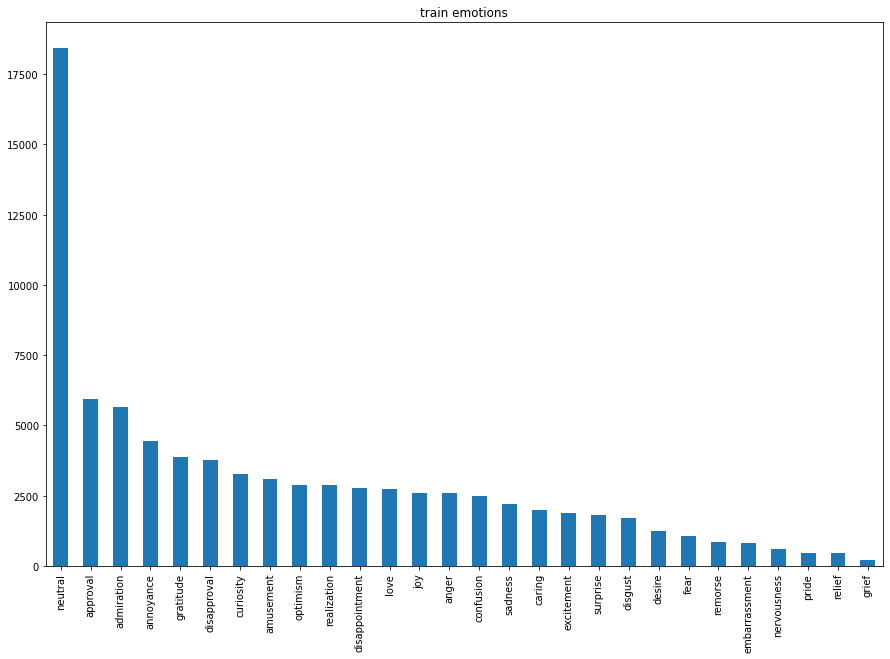

In [8]:
# plot the number of appearances of each emotion in the train dataset

fig, ax = plt.subplots(figsize=(15,10))
emotions = train
emotions = emotions.drop(['text'], axis = 1)
emotions.sum(axis = 0, skipna = True).sort_values(ascending=False).plot(kind='bar', ax=ax)
plt.title("train emotions")
plt.show()

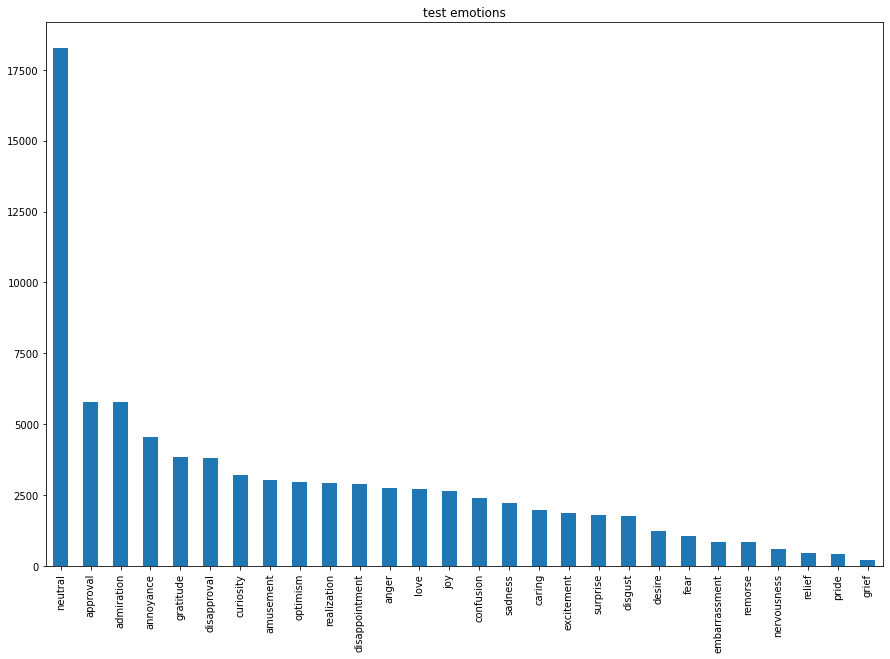

In [9]:
fig, ax = plt.subplots(figsize=(15,10))
emotions = test
emotions = emotions.drop(['text'], axis = 1)
emotions.sum(axis = 0, skipna = True).sort_values(ascending=False).plot(kind='bar', ax=ax)
plt.title("test emotions")
plt.show()

We can already see that "neutral" emotion isn't present in the train dataset, and is too much there in the test dataset. In order to improve the predictions, we will remove it. Also, the dataset is not balanced through all categories. We can improve it. Let see first our model baseline below.

In [10]:
# train
labels_train = train.drop(['text'], axis = 1)
labels_train = np.array(labels_train)
# validation
labels_val = evaluate.drop(['text'], axis = 1)
labels_val = np.array(labels_val)
# test
labels_test = test.drop(['text'], axis = 1)
labels_test = np.array(labels_test)
labels_test.shape

(70000, 28)

In [11]:
# tokenize : breaking the sentences into word parts
# create an element token
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
# fit it on train data
tokenizer.fit_on_texts(train["text"])

# tokenize the text with the same size
sequences_training_words = tokenizer.texts_to_sequences(train["text"])
padded_train = pad_sequences(sequences_training_words,maxlen=max_length, truncating=trunc_type)
padded_train = np.array(padded_train)

# validation
sequences_val_words = tokenizer.texts_to_sequences(evaluate["text"])
padded_val = pad_sequences(sequences_val_words,maxlen=max_length, truncating=trunc_type)
padded_val = np.array(padded_val)

# test
sequences_testing_words = tokenizer.texts_to_sequences(test["text"])
padded_test = pad_sequences(sequences_testing_words,maxlen=max_length, truncating=trunc_type)
padded_test = np.array(padded_test)

# Model Training

In [12]:
padded_train.size

7000000

In [13]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(28, activation='softmax')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 16)           160000    
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 24)                408       
                                                                 
 dense_1 (Dense)             (None, 28)                700       
                                                                 
Total params: 161,108
Trainable params: 161,108
Non-trainable params: 0
_________________________________________________________________


In [15]:
num_epochs = 15
history = model.fit(padded_train, labels_train, epochs=num_epochs, validation_data=(padded_val, labels_val), verbose=2)

Epoch 1/15
2188/2188 - 13s - loss: 0.1793 - accuracy: 0.2494 - val_loss: 0.1566 - val_accuracy: 0.2614 - 13s/epoch - 6ms/step
Epoch 2/15
2188/2188 - 10s - loss: 0.1562 - accuracy: 0.2632 - val_loss: 0.1561 - val_accuracy: 0.2614 - 10s/epoch - 5ms/step
Epoch 3/15
2188/2188 - 12s - loss: 0.1555 - accuracy: 0.2632 - val_loss: 0.1550 - val_accuracy: 0.2614 - 12s/epoch - 5ms/step
Epoch 4/15
2188/2188 - 12s - loss: 0.1516 - accuracy: 0.2806 - val_loss: 0.1495 - val_accuracy: 0.2938 - 12s/epoch - 5ms/step
Epoch 5/15
2188/2188 - 10s - loss: 0.1471 - accuracy: 0.2997 - val_loss: 0.1472 - val_accuracy: 0.2980 - 10s/epoch - 5ms/step
Epoch 6/15
2188/2188 - 10s - loss: 0.1439 - accuracy: 0.3106 - val_loss: 0.1438 - val_accuracy: 0.3133 - 10s/epoch - 5ms/step
Epoch 7/15
2188/2188 - 10s - loss: 0.1403 - accuracy: 0.3248 - val_loss: 0.1411 - val_accuracy: 0.3271 - 10s/epoch - 5ms/step
Epoch 8/15
2188/2188 - 10s - loss: 0.1368 - accuracy: 0.3400 - val_loss: 0.1388 - val_accuracy: 0.3401 - 10s/epoch - 5

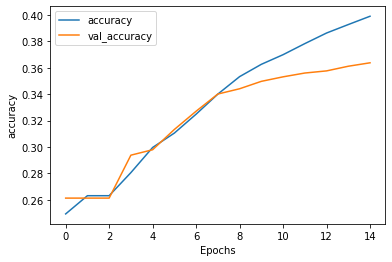

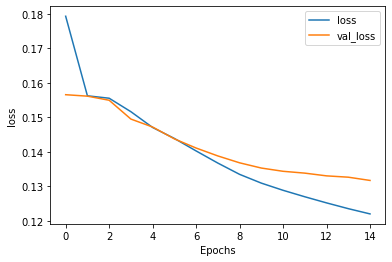

In [16]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [17]:
sentence = ["Wow it is amazing what you've done"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
prediction = model.predict(padded)

1/1 [==============================] - 0s 72ms/step


In [18]:
prediction = prediction > 0.5 
prediction

array([[ True, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False]])

In [19]:
test.columns[1]

'admiration'

In [20]:
labels_output = model.predict(padded_test)


2188/2188 [==============================] - 3s 1ms/step


In [21]:
print("Evaluate model on test data")
results = model.evaluate(padded_test, labels_test, batch_size=128)
print("test loss, test acc:", results)

labels_output = (labels_output > 0.5)

print(classification_report(labels_test, y_pred=labels_output, target_names=test.columns[1:]))

Evaluate model on test data
547/547 [==============================] - 1s 2ms/step - loss: 0.1322 - accuracy: 0.3618
test loss, test acc: [0.13216498494148254, 0.3618285655975342]
                precision    recall  f1-score   support

    admiration       0.64      0.25      0.36      5773
     amusement       0.63      0.34      0.44      3044
         anger       0.46      0.01      0.02      2762
     annoyance       0.00      0.00      0.00      4557
      approval       0.57      0.00      0.00      5785
        caring       0.00      0.00      0.00      1985
     confusion       0.67      0.01      0.02      2388
     curiosity       0.63      0.02      0.04      3190
        desire       0.00      0.00      0.00      1245
disappointment       0.00      0.00      0.00      2894
   disapproval       0.31      0.00      0.00      3798
       disgust       0.00      0.00      0.00      1753
 embarrassment       0.00      0.00      0.00       856
    excitement       0.00      0.00

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [22]:
# print f1 score for the baseline model
labels_output = np.array(labels_output)
labels_output = np.argmax(labels_output, axis=1)
labels_test_f1 = np.argmax(labels_test, axis=1)
print(f1_score(labels_test_f1, labels_output, average='macro'))

0.08485410887478147


## First conclusion

We tried this simple model baseline. To improve it, We can already remove the "neutral" emotion, optimize hyperparameters, add some layers as LSTM, normalize, create some master catergories of emotions... Let's go deep in this way !

# Remove "neutral" emotion

In [23]:
# clean the dataset

train = train.drop(['neutral'], axis = 1)
test =test.drop(['neutral'], axis = 1)
evaluate =evaluate.drop(['neutral'], axis = 1)

In [24]:
# train
labels_train = train.drop(['text'], axis = 1)
labels_train = np.array(labels_train)
# validation
labels_val = evaluate.drop(['text'], axis = 1)
labels_val = np.array(labels_val)
# test
labels_test = test.drop(['text'], axis = 1)
labels_test = np.array(labels_test)
labels_test.shape

(70000, 27)

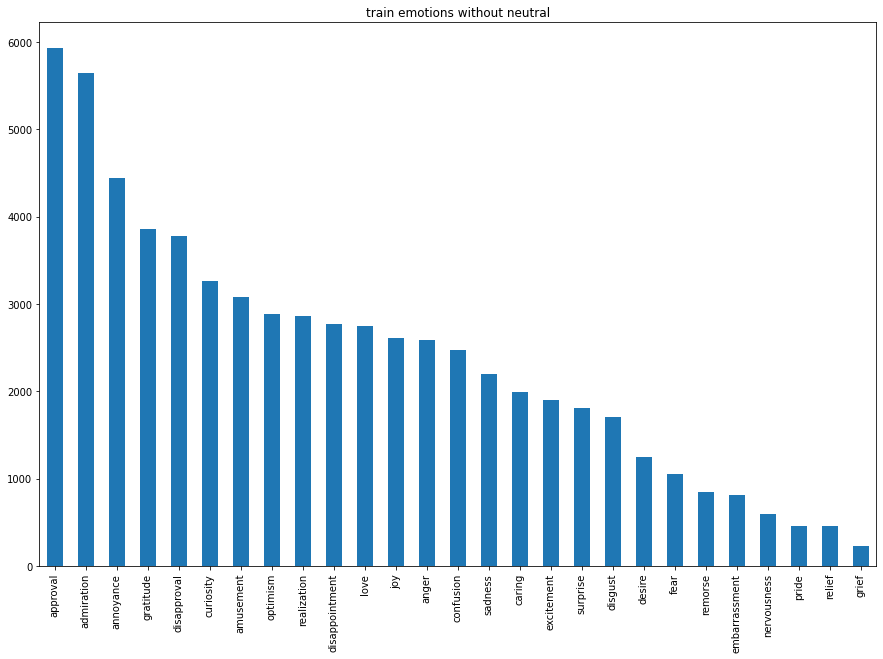

In [25]:
fig, ax = plt.subplots(figsize=(15,10))
emotions = train
emotions = emotions.drop(['text'], axis = 1)
emotions.sum(axis = 0, skipna = True).sort_values(ascending=False).plot(kind='bar', ax=ax)
plt.title("train emotions without neutral")
plt.show()

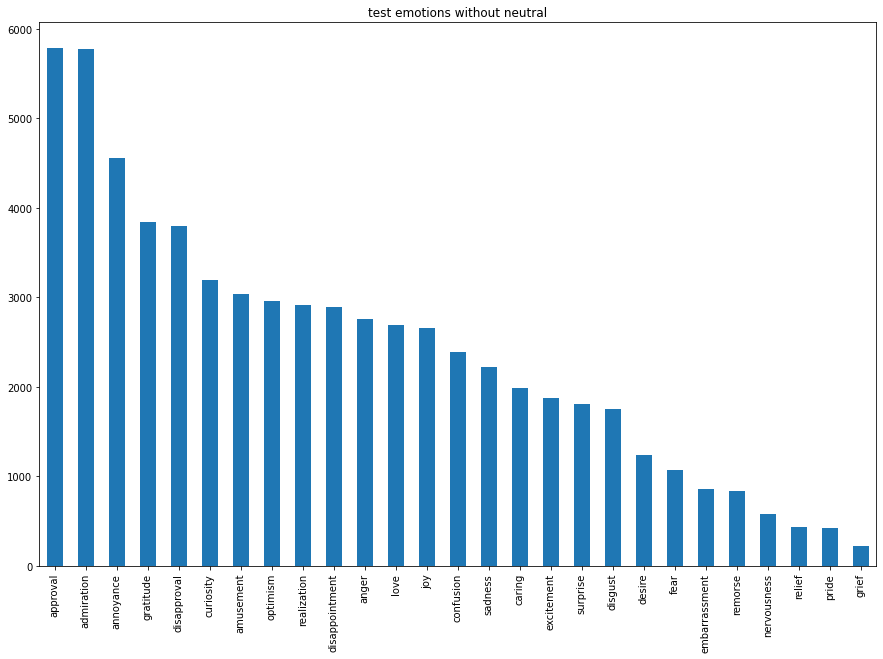

In [26]:
fig, ax = plt.subplots(figsize=(15,10))
emotions = test
emotions = emotions.drop(['text'], axis = 1)
emotions.sum(axis = 0, skipna = True).sort_values(ascending=False).plot(kind='bar', ax=ax)
plt.title("test emotions without neutral")
plt.show()

In [27]:
# tokenize : breaking the sentences into word parts
# create an element token
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
# fit it on train data
tokenizer.fit_on_texts(train["text"])

# tokenize the text with the same size
sequences_training_words = tokenizer.texts_to_sequences(train["text"])
padded_train = pad_sequences(sequences_training_words,maxlen=max_length, truncating=trunc_type)
padded_train = np.array(padded_train)

# validation
sequences_val_words = tokenizer.texts_to_sequences(evaluate["text"])
padded_val = pad_sequences(sequences_val_words,maxlen=max_length, truncating=trunc_type)
padded_val = np.array(padded_val)

# test
sequences_testing_words = tokenizer.texts_to_sequences(test["text"])
padded_test = pad_sequences(sequences_testing_words,maxlen=max_length, truncating=trunc_type)
padded_test = np.array(padded_test)

In [28]:
model_neutral = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(27, activation='softmax') # remove one emotion
])
model_neutral.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [29]:
num_epochs = 10
history_n = model_neutral.fit(padded_train, labels_train, epochs=num_epochs, validation_data=(padded_val, labels_val), verbose=2)

Epoch 1/10
2188/2188 - 12s - loss: 0.1691 - accuracy: 0.1431 - val_loss: 0.1410 - val_accuracy: 0.0730 - 12s/epoch - 6ms/step
Epoch 2/10
2188/2188 - 11s - loss: 0.1405 - accuracy: 0.1561 - val_loss: 0.1406 - val_accuracy: 0.3541 - 11s/epoch - 5ms/step
Epoch 3/10
2188/2188 - 12s - loss: 0.1398 - accuracy: 0.1492 - val_loss: 0.1393 - val_accuracy: 0.1030 - 12s/epoch - 5ms/step
Epoch 4/10
2188/2188 - 12s - loss: 0.1369 - accuracy: 0.1741 - val_loss: 0.1354 - val_accuracy: 0.1557 - 12s/epoch - 5ms/step
Epoch 5/10
2188/2188 - 11s - loss: 0.1335 - accuracy: 0.1807 - val_loss: 0.1335 - val_accuracy: 0.2371 - 11s/epoch - 5ms/step
Epoch 6/10
2188/2188 - 11s - loss: 0.1316 - accuracy: 0.1805 - val_loss: 0.1319 - val_accuracy: 0.1538 - 11s/epoch - 5ms/step
Epoch 7/10
2188/2188 - 10s - loss: 0.1293 - accuracy: 0.1932 - val_loss: 0.1297 - val_accuracy: 0.2229 - 10s/epoch - 5ms/step
Epoch 8/10
2188/2188 - 10s - loss: 0.1266 - accuracy: 0.2089 - val_loss: 0.1275 - val_accuracy: 0.1941 - 10s/epoch - 5

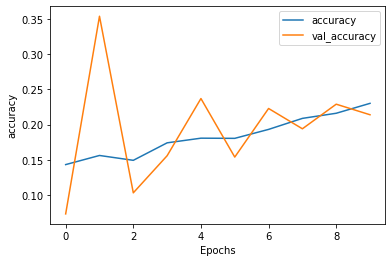

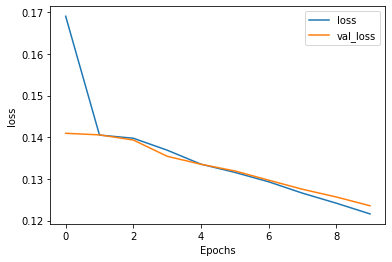

In [30]:
plot_graphs(history_n, "accuracy")
plot_graphs(history_n, "loss")

In [31]:
labels_test

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

In [32]:
print("Evaluate model on test data")
results_neutral = model_neutral.evaluate(padded_test, labels_test, batch_size=128)
print("test loss, test acc:", results_neutral)

labels_output_n = model_neutral.predict(padded_test)
labels_output_n = labels_output_n > 0.5
print(classification_report(labels_test, y_pred=labels_output_n, target_names=test.columns[1:]))

Evaluate model on test data
547/547 [==============================] - 1s 2ms/step - loss: 0.1239 - accuracy: 0.2206
test loss, test acc: [0.12392885237932205, 0.2206428498029709]
2188/2188 [==============================] - 3s 1ms/step
                precision    recall  f1-score   support

    admiration       0.65      0.18      0.28      5773
     amusement       0.60      0.00      0.00      3044
         anger       0.00      0.00      0.00      2762
     annoyance       0.00      0.00      0.00      4557
      approval       0.00      0.00      0.00      5785
        caring       0.00      0.00      0.00      1985
     confusion       0.00      0.00      0.00      2388
     curiosity       0.00      0.00      0.00      3190
        desire       0.00      0.00      0.00      1245
disappointment       0.00      0.00      0.00      2894
   disapproval       0.00      0.00      0.00      3798
       disgust       0.00      0.00      0.00      1753
 embarrassment       0.00      0.0

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [33]:
labels_output_n = np.array(labels_output_n)
labels_output_n = np.argmax(labels_output_n, axis=1)
labels_test_f1 = np.argmax(labels_test, axis=1)
print(f1_score(labels_test_f1, labels_output_n, average='macro'))

0.06052519049931072


# Add a LSTM layer

In [34]:
model_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.LSTM(20),
    tf.keras.layers.Dense(27, activation='softmax')
])
model_lstm.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [35]:
model_lstm.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 16)           160000    
                                                                 
 dense_4 (Dense)             (None, 100, 24)           408       
                                                                 
 lstm (LSTM)                 (None, 20)                3600      
                                                                 
 dense_5 (Dense)             (None, 27)                567       
                                                                 
Total params: 164,575
Trainable params: 164,575
Non-trainable params: 0
_________________________________________________________________


In [36]:
num_epochs = 15
history_lstm = model_lstm.fit(padded_train, labels_train, epochs=num_epochs, validation_data=(padded_val, labels_val), verbose=2)

Epoch 1/15
2188/2188 - 24s - loss: 0.1540 - accuracy: 0.1633 - val_loss: 0.1412 - val_accuracy: 0.1368 - 24s/epoch - 11ms/step
Epoch 2/15
2188/2188 - 24s - loss: 0.1368 - accuracy: 0.1552 - val_loss: 0.1316 - val_accuracy: 0.1759 - 24s/epoch - 11ms/step
Epoch 3/15
2188/2188 - 24s - loss: 0.1286 - accuracy: 0.1886 - val_loss: 0.1281 - val_accuracy: 0.2042 - 24s/epoch - 11ms/step
Epoch 4/15
2188/2188 - 24s - loss: 0.1242 - accuracy: 0.2164 - val_loss: 0.1246 - val_accuracy: 0.2160 - 24s/epoch - 11ms/step
Epoch 5/15
2188/2188 - 21s - loss: 0.1200 - accuracy: 0.2324 - val_loss: 0.1224 - val_accuracy: 0.2165 - 21s/epoch - 10ms/step
Epoch 6/15
2188/2188 - 21s - loss: 0.1168 - accuracy: 0.2423 - val_loss: 0.1213 - val_accuracy: 0.2248 - 21s/epoch - 10ms/step
Epoch 7/15
2188/2188 - 21s - loss: 0.1143 - accuracy: 0.2503 - val_loss: 0.1201 - val_accuracy: 0.2320 - 21s/epoch - 10ms/step
Epoch 8/15
2188/2188 - 21s - loss: 0.1120 - accuracy: 0.2599 - val_loss: 0.1192 - val_accuracy: 0.2372 - 21s/ep

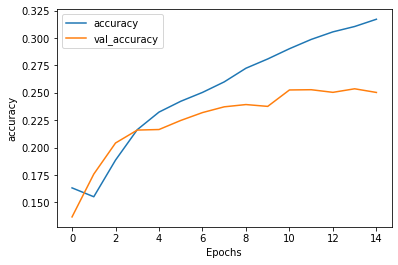

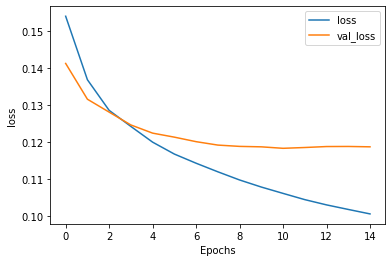

In [37]:
plot_graphs(history_lstm, "accuracy")
plot_graphs(history_lstm, "loss")

In [38]:
output_lstm = model_lstm.predict(padded_test)

2188/2188 [==============================] - 8s 3ms/step


In [39]:
print("Evaluate model on test data")
results_lstm = model_lstm.evaluate(padded_test, labels_test, batch_size=128)
print("test loss, test acc:", results_lstm)

output_lstm = output_lstm > 0.5
print(classification_report(labels_test, y_pred=output_lstm, target_names=test.columns[1:]))

Evaluate model on test data
547/547 [==============================] - 3s 5ms/step - loss: 0.1193 - accuracy: 0.2519
test loss, test acc: [0.11933641135692596, 0.25191429257392883]
                precision    recall  f1-score   support

    admiration       0.55      0.39      0.45      5773
     amusement       0.57      0.46      0.51      3044
         anger       0.40      0.01      0.02      2762
     annoyance       0.41      0.00      0.01      4557
      approval       0.22      0.04      0.06      5785
        caring       0.34      0.01      0.02      1985
     confusion       0.59      0.01      0.02      2388
     curiosity       0.37      0.03      0.05      3190
        desire       0.00      0.00      0.00      1245
disappointment       0.00      0.00      0.00      2894
   disapproval       0.28      0.05      0.08      3798
       disgust       0.74      0.03      0.06      1753
 embarrassment       0.00      0.00      0.00       856
    excitement       0.28      0.0

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [40]:
output_lstm = np.array(output_lstm)
output_lstm = np.argmax(output_lstm, axis=1)
print(f1_score(labels_test_f1, output_lstm, average='macro'))

0.11713463977165937


# Try with normalization the text

In [41]:
# labels are already standardized
padded_train_norm = preprocessing.normalize(padded_train)
padded_val_norm = preprocessing.normalize(padded_val)
padded_test_norm = preprocessing.normalize(padded_test)

In [42]:
# change the learning rate

model_norm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.LSTM(20),
    tf.keras.layers.Dense(27, activation='softmax')
])

opt = keras.optimizers.Adam(learning_rate=0.01)
model_norm.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])



In [43]:
history_norm = model_norm.fit(padded_train_norm, labels_train, epochs=num_epochs, validation_data=(padded_val_norm, labels_val), verbose=2)

Epoch 1/15
2188/2188 - 23s - loss: 0.1549 - accuracy: 0.1497 - val_loss: 0.1418 - val_accuracy: 0.0730 - 23s/epoch - 11ms/step
Epoch 2/15
2188/2188 - 21s - loss: 0.1415 - accuracy: 0.1743 - val_loss: 0.1417 - val_accuracy: 0.0730 - 21s/epoch - 10ms/step
Epoch 3/15
2188/2188 - 24s - loss: 0.1415 - accuracy: 0.1492 - val_loss: 0.1417 - val_accuracy: 0.0753 - 24s/epoch - 11ms/step
Epoch 4/15
2188/2188 - 24s - loss: 0.1415 - accuracy: 0.1723 - val_loss: 0.1417 - val_accuracy: 0.0730 - 24s/epoch - 11ms/step
Epoch 5/15
2188/2188 - 21s - loss: 0.1415 - accuracy: 0.1700 - val_loss: 0.1416 - val_accuracy: 0.0753 - 21s/epoch - 10ms/step
Epoch 6/15
2188/2188 - 22s - loss: 0.1415 - accuracy: 0.1717 - val_loss: 0.1417 - val_accuracy: 0.0730 - 22s/epoch - 10ms/step
Epoch 7/15
2188/2188 - 21s - loss: 0.1415 - accuracy: 0.1601 - val_loss: 0.1416 - val_accuracy: 0.0730 - 21s/epoch - 10ms/step
Epoch 8/15
2188/2188 - 21s - loss: 0.1415 - accuracy: 0.1639 - val_loss: 0.1417 - val_accuracy: 0.3582 - 21s/ep

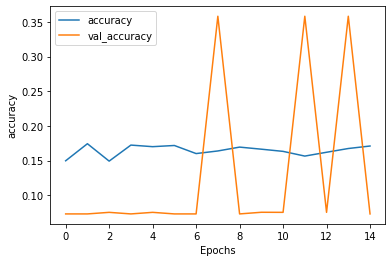

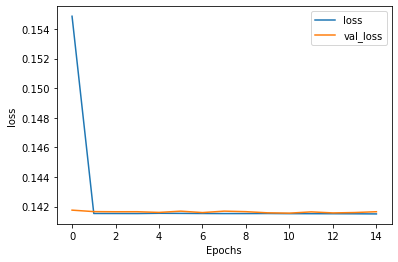

In [44]:
plot_graphs(history_norm, "accuracy")
plot_graphs(history_norm, "loss")

In [45]:
print("Evaluate model on test data")
results_norm = model_norm.evaluate(padded_test_norm, labels_test, batch_size=128)
print("test loss, test acc:", results_norm)

labels_output_norm = model_norm.predict(padded_test)
labels_output_norm = labels_output_norm > 0.5
print(classification_report(labels_test, y_pred=labels_output_norm, target_names=test.columns[1:]))

Evaluate model on test data
547/547 [==============================] - 3s 5ms/step - loss: 0.1421 - accuracy: 0.0731
test loss, test acc: [0.14210903644561768, 0.073085717856884]
2188/2188 [==============================] - 8s 3ms/step
                precision    recall  f1-score   support

    admiration       0.00      0.00      0.00      5773
     amusement       0.00      0.00      0.00      3044
         anger       0.00      0.00      0.00      2762
     annoyance       0.00      0.00      0.00      4557
      approval       0.00      0.00      0.00      5785
        caring       0.00      0.00      0.00      1985
     confusion       0.00      0.00      0.00      2388
     curiosity       0.00      0.00      0.00      3190
        desire       0.00      0.00      0.00      1245
disappointment       0.00      0.00      0.00      2894
   disapproval       0.00      0.00      0.00      3798
       disgust       0.00      0.00      0.00      1753
 embarrassment       0.00      0.00

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1

In [46]:
labels_output_norm = np.array(labels_output_norm)
labels_output_norm = np.argmax(labels_output_norm, axis=1)
print(f1_score(labels_test_f1, labels_output_norm, average='macro'))

0.019564899985399325


It was expected to win in accuracy with normalization, this is true, however the resukts are chaotic ! 

## Merge columns in master category

In [47]:
emotions_list = train.columns[1:]
emotions_list

cat_emotions_list = ['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise']

In [48]:

# function that creates categories of emotions
def emotions_to_cat(emotions_labels):
    
    # create a dataframe of emotions labels
    df_emotions = pd.DataFrame(emotions_labels, columns=emotions_list)

    # create a dataframe of categories labels
    df_cat  = pd.DataFrame(np.zeros((len(emotions_labels), len(cat_emotions_list))), columns=cat_emotions_list)

    for i in range(len(df_emotions)): # for each line of the emotions dataframe

        if df_emotions.loc[i,['anger', 'annoyance', 'disapproval']].sum() >= 1:
            df_cat.loc[i,'anger'] = 1 # if we find at least one of this emotions we fill the categorie df with the correponding category

        if df_emotions.loc[i,'disgust'].sum() >= 1:
            df_cat.loc[i,'disgust'] = 1

        if df_emotions.loc[i,['fear', 'nervousness']].sum() >= 1:
            df_cat.loc[i,'fear'] = 1

        if df_emotions.loc[i,['joy', 'amusement', 'approval', 'excitement', 'gratitude',
                        'love', 'optimism', 'relief', 'pride', 'admiration', 'desire','caring']].sum() >= 1:
            df_cat.loc[i,'joy'] = 1 

        if df_emotions.loc[i,['sadness', 'disappointment', 'embarrassment', 'grief', 'remorse']].sum() >= 1:
            df_cat.loc[i,'sadness'] = 1

        if df_emotions.loc[i,['surprise', 'realization', 'confusion', 'curiosity']].sum() >= 1:
            df_cat.loc[i,'surprise'] = 1

    return df_cat.values

In [ ]:
# Mapping GoEmotion labels to Ekman labels (true and predictions)
labels_test_cat = emotions_to_cat(labels_test)
output_labels = model_lstm.predict(padded_test)
labels_output_cat = emotions_to_cat(output_labels)
    

In [ ]:
labels_test_cat

In [ ]:
labels_output_cat

In [ ]:
# retrain with new categories
labels_train_cat = emotions_to_cat(labels_train)
labels_val_cat = emotions_to_cat(labels_val)

In [ ]:
# updated model
model_cat_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.LSTM(20),
    tf.keras.layers.Dense(6, activation='softmax') # change number of outputs
])
model_cat_lstm.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
num_epochs = 15
history_cat = model_cat_lstm.fit(padded_train, labels_train_cat, epochs=num_epochs, validation_data=(padded_val, labels_val_cat), verbose=2)

In [ ]:
plot_graphs(history_cat, "accuracy")
plot_graphs(history_cat, "loss")

In [ ]:
labels_output_cat = model_cat_lstm.predict(padded_test)

In [ ]:
print("Evaluate model_cat on test data")
results_cat = model_cat_lstm.evaluate(padded_test, labels_test_cat, batch_size=128)
print("test loss, test acc:", results_cat)

labels_output_cat = (labels_output_cat > 0.5)
labels_output_cat
print(classification_report(labels_test_cat, y_pred=labels_output_cat, target_names=cat_emotions_list))

In [ ]:
labels_output_cat = np.array(labels_output_cat)
labels_output_cat = np.argmax(labels_output_cat, axis=1)
print(f1_score(labels_test_f1, labels_output_cat, average='macro'))